In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#!pip install pgmpy

#!pip install daft

In [19]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.models import ClusterGraph
from pgmpy.inference import CausalInference

In [20]:
NCmodel = BayesianNetwork()
NCmodel.add_node("ZipCode")
NCmodel.add_node("HaveCar")
NCmodel.add_node("PerCapitaIncome")
NCmodel.add_node("Havejob")
NCmodel.add_node("CommuteTime")
NCmodel.add_node("BusRidership")
NCmodel.add_node("Race")
NCmodel.add_node("UnemploymentRate")
#NCmodel.add_node("Weekday")


#NCmodel.add_edge("ZipCode","CommuteTime")
NCmodel.add_edge("ZipCode", "HaveCar")
#NCmodel.add_edge("ZipCode", "BusRidership")
NCmodel.add_edge("ZipCode", "UnemploymentRate")
NCmodel.add_edge("HaveCar", "PerCapitaIncome")
#NCmodel.add_edge("HaveCar", "Havejob")
#NCmodel.add_edge("PerCapitaIncome", "Havejob")

#NCmodel.add_edge("Havejob", "BusRidership")
#NCmodel.add_edge("UnemploymentRate","Havejob")
#NCmodel.add_edge("Weekday","Havejob")

NCmodel.add_edge("CommuteTime", "BusRidership")

NCmodel.add_edge("Race", "ZipCode")
NCmodel.add_edge("UnemploymentRate", "Havejob")
#NCmodel.add_edge("UnemploymentRate", "BusRidership")
#NCmodel.add_edge("Weekday", "Havejob")



<Axes:>

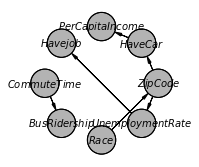

In [21]:
NCmodel.to_daft().render()


In [25]:
from sklearn.preprocessing import normalize

In [22]:
NCmodel.get_children("CommuteTime")

['BusRidership']

In [137]:
cpd_Race = TabularCPD('Race', variable_card=3,values=[[.83],[ .13], [.04]],state_names={"Race":['Black','White','Other']})
cpd_ZipCode = TabularCPD ('ZipCode', variable_card=3, values=[
[.8, .15,.05], 
[.15, .05,.8], 
[.05, .8,.15]],
evidence=['Race'], evidence_card=[3], state_names={"ZipCode":['27101','27105','27107'],"Race":['Black','White','Other']})
cpd_CommuteTime = TabularCPD('CommuteTime', variable_card=4, values=
[[.04],[.07],[.39],[.50]])
cpd_Havejob = TabularCPD('Havejob', variable_card=3, values=
[[.71,.29,0], 
[.29,.71,0],
[0,0,1]], evidence=['UnemploymentRate'],evidence_card=[3], state_names={"Havejob":["Has","HasNot", "Other"],'UnemploymentRate':['Working','Nonworking','Other']})
#cpd_Weekday = TabularCPD('Weekday', variable_card=7, values=[[.143], [.143],[.143], [.143], [.143], [.143], [.142]])

cpd_HaveCar = TabularCPD('HaveCar', variable_card=3, values=[
[.6, .39,0],
 [.2, .41,1],
 [.2,.2,0]],
 evidence=['ZipCode'], evidence_card=[3],state_names={"HaveCar":["Has","HasNot"],"ZipCode":['27101','27105','27107']})
cpd_PerCapitaIncome = TabularCPD ('PerCapitaIncome', variable_card=2, values=
[[.72, .28,0], 
[.28,.72,1]],
evidence=['HaveCar'],evidence_card=[3], state_names={"PerCapitaIncome":["Above","Below"],"HaveCar":["Has","HasNot"]})
cpd_UnemploymentRate = TabularCPD ('UnemploymentRate', variable_card=3, values=[
[.89,.11,0], 
[.11,.89,1],
[0,0,0]
],evidence=["ZipCode"], evidence_card=[3],state_names={'UnemploymentRate':['Working','Nonworking','Other'],"ZipCode":['27101','27105','27107']})

cpd_BusRidership = TabularCPD('BusRidership', variable_card=4,values=
[[1,.5,.5,0],
[0,0,.5,0],
[0,.5,0,1],
[0,0,0,0]],
 evidence=["CommuteTime"],evidence_card=[4])




NCmodel.add_cpds(cpd_CommuteTime, cpd_HaveCar, cpd_PerCapitaIncome, cpd_UnemploymentRate, cpd_ZipCode, cpd_BusRidership, cpd_Havejob, cpd_Race)


In [95]:
NCmodel.get_children("UnemploymentRate")

['Havejob']

TODO:  (Example) state_names={'G': ['A', 'B', 'C'],
                                    'I': ['Dumb', 'Intelligent'],
                                    'D': ['Easy', 'Hard']}) 

In [138]:
NCmodel.check_model()

True

In [105]:
print(cpd_CommuteTime)

+----------------+------+
| CommuteTime(0) | 0.04 |
+----------------+------+
| CommuteTime(1) | 0.07 |
+----------------+------+
| CommuteTime(2) | 0.39 |
+----------------+------+
| CommuteTime(3) | 0.5  |
+----------------+------+


In [106]:
print(cpd_BusRidership)

+-----------------+----------------+-----+----------------+----------------+
| CommuteTime     | CommuteTime(0) | ... | CommuteTime(2) | CommuteTime(3) |
+-----------------+----------------+-----+----------------+----------------+
| BusRidership(0) | 1.0            | ... | 0.5            | 0.0            |
+-----------------+----------------+-----+----------------+----------------+
| BusRidership(1) | 0.0            | ... | 0.5            | 0.0            |
+-----------------+----------------+-----+----------------+----------------+
| BusRidership(2) | 0.0            | ... | 0.0            | 1.0            |
+-----------------+----------------+-----+----------------+----------------+
| BusRidership(3) | 0.0            | ... | 0.0            | 0.0            |
+-----------------+----------------+-----+----------------+----------------+


In [8]:
NCmodel.get_parents("CommuteTime")

[]

In [9]:
NCmodel.get_children("CommuteTime")

['BusRidership']

In [104]:
NCmodel.check_model()

True

In [11]:
NCmodel.get_children("HaveCar")

['PerCapitaIncome']

In [139]:
NCmodel.get_cardinality()

defaultdict(int,
            {'CommuteTime': 4,
             'HaveCar': 3,
             'PerCapitaIncome': 2,
             'UnemploymentRate': 3,
             'ZipCode': 3,
             'BusRidership': 4,
             'Havejob': 3,
             'Race': 3})

In [140]:
NCmodel.nodes()

NodeView(('ZipCode', 'HaveCar', 'PerCapitaIncome', 'Havejob', 'CommuteTime', 'BusRidership', 'Race', 'UnemploymentRate'))

In [141]:
infer = VariableElimination(NCmodel)
g_dist = infer.query(['Havejob'])
print(g_dist) 
NCmodel.active_trail_nodes('PerCapitaIncome')

+-----------------+----------------+
| Havejob         |   phi(Havejob) |
+=================+================+
| Havejob(Has)    |         0.5538 |
+-----------------+----------------+
| Havejob(HasNot) |         0.4462 |
+-----------------+----------------+
| Havejob(Other)  |         0.0000 |
+-----------------+----------------+


{'PerCapitaIncome': {'HaveCar',
  'Havejob',
  'PerCapitaIncome',
  'Race',
  'UnemploymentRate',
  'ZipCode'}}

In [142]:
NCmodel.get_cpds()

[<TabularCPD representing P(CommuteTime:4) at 0x7fc1119351f0>,
 <TabularCPD representing P(HaveCar:3 | ZipCode:3) at 0x7fc12604a0a0>,
 <TabularCPD representing P(PerCapitaIncome:2 | HaveCar:3) at 0x7fc0f13f8fd0>,
 <TabularCPD representing P(UnemploymentRate:3 | ZipCode:3) at 0x7fc0f1401be0>,
 <TabularCPD representing P(ZipCode:3 | Race:3) at 0x7fc103971790>,
 <TabularCPD representing P(BusRidership:4 | CommuteTime:4) at 0x7fc1119357c0>,
 <TabularCPD representing P(Havejob:3 | UnemploymentRate:3) at 0x7fc111935550>,
 <TabularCPD representing P(Race:3) at 0x7fc103971a30>]

In [16]:
print()

In [108]:
NCmodel.local_independencies('BusRidership')

(BusRidership ⟂ HaveCar, Race, PerCapitaIncome, ZipCode, UnemploymentRate, Havejob | CommuteTime)

In [119]:
NCmodel.local_independencies(['BusRidership', 'Havejob']) 

(BusRidership ⟂ HaveCar, Race, PerCapitaIncome, ZipCode, UnemploymentRate, Havejob | CommuteTime)
(Havejob ⟂ HaveCar, CommuteTime, Race, PerCapitaIncome, ZipCode, BusRidership | UnemploymentRate)

In [132]:
infer.map_query(['Race'])


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Race': 'Black'}

In [133]:
infer.map_query(['HaveCar'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'HaveCar': 'Has'}

In [134]:
infer.map_query(["ZipCode"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'ZipCode': '27101'}

In [143]:
infer.map_query(["Havejob"])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'Havejob': 'Has'}

In [123]:
NCmodel.active_trail_nodes('PerCapitaIncome')

{'PerCapitaIncome': {'HaveCar',
  'Havejob',
  'PerCapitaIncome',
  'Race',
  'UnemploymentRate',
  'ZipCode'}}

In [147]:
print(infer.query(['Havejob'], evidence={'Race': 'Black', 'ZipCode': '27107'}))

+-----------------+----------------+
| Havejob         |   phi(Havejob) |
+=================+================+
| Havejob(Has)    |         0.2900 |
+-----------------+----------------+
| Havejob(HasNot) |         0.7100 |
+-----------------+----------------+
| Havejob(Other)  |         0.0000 |
+-----------------+----------------+
